In [1]:
# Assignment-Capstone_Data Science_Office Supply Store Data Analysis: 30.Nov.2019
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import pathlib
pd.set_option('display.max_columns', 50)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

# used for predictions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def read_data(file_path):    
    df = pd.read_excel(file_path)
    return df

def clean_and_organize_data(df):
    # drop the negative sales
    df = drop_negative_numbers(df)
        
    # no duplicate IDs detected - so no drop for that case
    
    # remove the outliers for 'Number of Prior Year Transactions'
    df = drop_outliers(df)
    
    df = add_new_columns(df)
    
    df = fill_no_of_employees_isna(df)
    
    df = set_Langage_Nan_To_English(df)
    
    df = language_column_update(df)
    
    print('df-type: ', type(df))
    
    df['Last Transaction Channel'] = df['Last Transaction Channel'].fillna('unknown')
    
    # Desk, Computer, Insurance, Toner are irregular
    #products_all = ['Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Office Supplies', 
     #              'Desk', 'Computer', 'Insurance', 'Toner']
    products = ['Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Office Supplies']
    for col in df.columns:
        if col in products:
            df[col].iloc[:] = df[col].iloc[:].apply(convert_Y_N_to_1_0)
    
    df = update_last_transaction_channel(df)
    
    df = update_Desk(df)
    
    df = update_Computer(df)
    
    df = update_Insurance(df)
    
    df = update_Toner(df)
    
    # don't do this for now but keep that in mind
    #df = create_bins_for_columns(df)    
    
    return df
    
def convert_Y_N_to_1_0(x):
    if x == 'Y':
        return 1
    else:
        return 0

    '''
def set_na_to_0(df):
    for col in df:   
        if col != 'Date of First Purchase':
            if col in products_all:
                df[col] = df[col].fillna('N')
            else:
                df[col] = df[col].fillna(0)
    return df
'''
def set_na_to_0(df):
    for col in df:   
        if col != 'Date of First Purchase':
            df[col] = df[col].fillna(0)
    return df

def set_na_to_N(df):
    products_all = ['Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Office Supplies', 
                   'Desk', 'Computer', 'Insurance', 'Toner']
    for col in products_all:
        df[col] = df[col].fillna('N')
    return df

def drop_negative_numbers(df):    
    index_to_be_dropped = []
    index_to_be_dropped = np.array(index_to_be_dropped)
    for col in df.columns:
        if col in ['Campaign Period Sales', 'Historical Sales Volume', 'Number of Prior Year Transactions']:
            # e.g. negative_sale = df.loc[df['Campaign Period Sales'] < 0]
            index_to_be_dropped = np.append(index_to_be_dropped, df[df[col] < 0].index)           
        
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
    # df_test2=df_test2.drop([3, 3])  # drops index#=3 and 4
    # df.drop(columns=['B', 'C'])  # dopr columns B and C
    # df.drop(['B', 'C'], axis=1)  # dopr columns B and C
    # df_test2=df.drop(df_test1.loc[df_test1['Customer Number'] == 86734].index)
    # drop the row where Customer Number=86734
    # df.iloc[[4]]  # shows the row with the index=4
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
    # df.dropna(subset=['name', 'born'])
    # df.dropna(thresh=2)
    # df.dropna(how='all')
    
    
    #print(index_to_be_dropped.tolist())         # see the indexes
    #df.iloc[index_to_be_dropped.tolist(), :]    # check the data for these indexes
    # 5783 in df_test.index                      # check if the index exist in the dataFrame before and after drop
    
    # e.g. df = df.drop(negative_sale.index)
    df = df.drop(index_to_be_dropped.tolist())
    
    return df

def drop_outliers(df):
    # check numerical data types
    #for col in df.columns:
        #print('col={} \t col_dtype={}'.format(col, df[col].dtype))
    
    '''
    for col in df.columns:
        if df[col].dtype in ['float64'] and col not in ['Customer Number']:
            print('col={} \t col_dtype={}'.format(col, df[col].dtype))
    '''
    
    # historical sales might have outliers but didn't remove them since it was not mentioned in the videos
    # and I'm not familiar to the sales domain
    # but results can be revisited for a second time to see what happens if we remove the outlier for the history
    
    '''
    # below can be adjusted according to the std as done in 'Number of Prior Year Transactions' 
    print('\nhigh purchases: ', df[df['Campaign Period Sales'] > 
                               df['Campaign Period Sales'].mean()*20]['Date of First Purchase'].dt.year.unique())
    print('\naverage/low purchases', df[df['Campaign Period Sales'] < 
                                        df['Campaign Period Sales'].mean()*20]['Date of First Purchase'].dt.year.unique())
    '''
    
    # other numerical columns are just 0-1 so no outlier is possible
    # df['Do Not Telemarket'].value_counts()
    # df['Historical Sales Volume'].value_counts()
    # df['Do Not Email'].value_counts()
    # df['Do Not Direct Mail Solicit'].value_counts()
    
    # if the value is 10 times farther than std to the mean, that can be ignored I guess..
    # drop ROW
    df = df.drop(df[df['Number of Prior Year Transactions'] > 
                    df['Number of Prior Year Transactions'].mean() + df['Number of Prior Year Transactions'].std()*10].index)
    
    '''
    NOTICE          11903
    AUTO RENEW       4268
    PAYMENT PLAN        1
    There is only 1 PAYMENT PLAN as a 'Repurchase Method'. But 'Campaign Period Sales' and 
    'Number of Prior Year Transactions' values can't be ignored.. so maybe instead of dropping,
    a grouping can be done as NOTICE vs OTHER_METHOD
    '''
    #df['Repurchase Method'].value_counts()
    
    return df

def buy_or_not_buy(x):
    if x > 0:
        return 'Y'
    else:
        return 'N'    
    
def repurchase_method_notice(x):
    if x == 'NOTICE': return 1
    else: return 0
    
def add_new_columns(df):
    # add a column to show purchased or not for the prediction
    df['made_purchase'] = df['Campaign Period Sales'].apply(buy_or_not_buy)
    df['repurchase_method'] = df['Repurchase Method'].apply(repurchase_method_notice)
    df['year_of_first_purchase'] = df['Date of First Purchase'].dt.year
    df['quarter_of_purchase'] = df['Date of First Purchase'].dt.quarter    
    return df

def convert_no_of_employees(val):
    if val == "1-5": return 3
    elif val == "6-10": return 8
    elif val == "11-50": return 30
    elif val == "51-100": return 75
    elif val == "101-500": return 300
    elif val == "500+": return 500
    else: return np.nan

def fill_no_of_employees_isna(df):    
    df['num_employee_converted'] = df['Number of Employees'].apply(convert_no_of_employees)
    #df['num_employee_converted'].median()  # 8.0
    df.loc[df['num_employee_converted'].isna(), 'num_employee_converted']=df['num_employee_converted'].median()    
    return df
    
def convert_last_transaction_channel(val):
    if val == "MAIL": return 1
    elif val == "AUTO RENEW": return 2
    elif val == "WEB": return 3
    elif val == "PHONE": return 4
    elif val == "BRANCH (POS)": return 5
    elif val == "BRANCH (PHONE)": return 6
    elif val == "BILLING": return 7
    elif val == "IT": return 8
    else: return 9

def update_last_transaction_channel(df):
    df['Last Transaction Channel'] = df['Last Transaction Channel'].apply(convert_last_transaction_channel)
    return df

def convert_Desk(x):
    if x == 'Y':        return 1
    else:        return 0

def update_Desk(df):
    df['Desk'] = df['Desk'].apply(convert_Desk)
    return df    

def convert_Computer(x):
    if x == 'Y':        return 1
    else:        return 0

def update_Computer(df):
    df['Computer'] = df['Computer'].apply(convert_Computer)
    return df

def convert_Insurance(x):
    if x == 'Y':        return 1
    else:        return 0

def update_Insurance(df):
    df['Insurance'] = df['Insurance'].apply(convert_Insurance)
    return df

def convert_Toner(x):
    if x == 'Y':        return 1
    else:        return 0

def update_Toner(df):
    df['Toner'] = df['Toner'].apply(convert_Toner)
    return df
    
# the majority is English so let's set NaN values to English
def set_Langage_Nan_To_English(df):
    df.loc[df['Language'].isna(), 'Language']='English'
    return df

def english_or_not(x):
    if x == 'English': return 1
    else: return 0
    
def language_column_update(df):
    df['Language'] = df['Language'].apply(english_or_not)
    return df

def create_bins_for_columns(df, no_bins=10):
    # cut: for equal-width
    # qcut: for equal-size
    df['year_of_first_purchase'], bins_year = pd.qcut(df['year_of_first_purchase'], 
                                                         q=no_bins, retbins=True, duplicates="drop", labels=False)
        
    df['Historical Sales Volume'], bins_year = pd.qcut(df['Historical Sales Volume'], 
                                                         q=no_bins, retbins=True, duplicates="drop", labels=False)
    
    '''
    # if equal-width:
    df['Historical Sales Volume'], bins_year = pd.cut(df['Historical Sales Volume'], 
                                                         no_bins, retbins=True, duplicates="drop", labels=False)
    '''
    
    return df

In [3]:
def split_data_to_train_test(X, y, test_size=0.50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    return X_train, X_test, y_train, y_test

######################## REGRESSION MODELS ########################
def LinR_model(X_train, y_train, X_test, y_test):
    LinR = LinearRegression()
    model_summary_LinR = LinR.fit(X_train, y_train)
    score_LinR = LinR.score(X_test, y_test)
    mse_LinR = mean_squared_error(y_test, LinR.predict(X_test))
    return LinR, model_summary_LinR, score_LinR, mse_LinR    

def DT_Regressor_model(X_train, y_train, X_test, y_test, max_depth=6):
    DT_R = DecisionTreeRegressor(max_depth = max_depth)
    model_summary_DT_Regressor = DT_R.fit(X_train, y_train)
    score_DT_R = DT_R.score(X_test, y_test)
    mse_DT_R = mean_squared_error(y_test, DT_R.predict(X_test))
    DT_R_res = pd.DataFrame({'feature': X_train.columns, 'importance': DT_R.feature_importances_})
    #tree_res.sort_values('importance', ascending=False)
    return DT_R, model_summary_DT_Regressor, score_DT_R, mse_DT_R, DT_R_res

def GS_CV_Pipe_model(pipe, params = {'poly__degree': [2, 3]}, cv=10):    
    #pipe = Pipeline([('poly', PolynomialFeatures()), ('lr', LinearRegression())])
    GS_CV = GridSearchCV(pipe, param_grid = params, cv=cv)
    model_summary_GS_CV_Pipe = GS_CV.fit(X_train, y_train)
    score_GS_CV = GS_CV.score(X_test, y_test)    
    mse_GS_CV = mean_squared_error(y_test, GS_CV.predict(X_test))
    GS_CV_best_params = GS_CV.best_params_
    return GS_CV, model_summary_GS_CV_Pipe, score_GS_CV, mse_GS_CV, GS_CV_best_params

def GS_CV_DTR_model(X_train, y_train, X_test, y_test, DT_Regressor, 
                    params1 = {'max_depth': [i for i in range(2,15)],'min_samples_split': [i for i in range(4,20)]}, cv=5):
    #GS_CV = GridSearchCV(DT_Regressor, param_grid = params, cv)
    GS_CV = GridSearchCV(DecisionTreeRegressor(), param_grid = params1, cv = cv)
    model_summary_GS_CV_DTR = GS_CV.fit(X_train, y_train)
    score_GS_CV = GS_CV.score(X_test, y_test)    
    mse_GS_CV = mean_squared_error(y_test, GS_CV.predict(X_test))
    GS_CV_best_params = GS_CV.best_params_
    return GS_CV, model_summary_GS_CV_DTR, score_GS_CV, mse_GS_CV, GS_CV_best_params

#def GS_CV_RF_R_model(params = {'max_depth': [5, 10, 15, 20], 'criterion': ['gini', 'entropy']}, n_estimators=100, cv=5):
def GS_CV_RF_R_model(X_train, y_train, X_test, y_test, params = 
                     {'max_depth': [i for i in range(2, 15)],'min_samples_split': [i for i in range(4, 20)]}, 
                     n_estimators=100, cv=5):
    GS_CV = GridSearchCV(RandomForestRegressor(n_estimators=n_estimators), param_grid = params, cv = cv)
    #model_summary_GS_CV_RF_R = GS_CV.fit(X_train, y_train)
    # https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
    model_summary_GS_CV_RF_R = GS_CV.fit(X_train, np.ravel(y_train))
    # train_y.values.ravel()
    score_GS_CV = GS_CV.score(X_test, y_test)    
    mse_GS_CV = mean_squared_error(y_test, GS_CV.predict(X_test))
    GS_CV_best_params = GS_CV.best_params_
    return GS_CV, model_summary_GS_CV_RF_R, score_GS_CV, mse_GS_CV, GS_CV_best_params

######################## CLASSIFIER MODELS ########################
# cv = Cross Validation
def LogR_model(X_train, y_train, X_test, y_test):
    LogR = LogisticRegression()
    model_summary_LogR = LogR.fit(X_train, y_train)
    score_LogR = LogR.score(X_test, y_test)
    #score_LogR = 0
    # TEST below
    # score_LogR= cross_val_score(LogR, X_test, y_test, cv=5, scoring='accuracy')
    mse_LogR = mean_squared_error(y_test, LogR.predict(X_test))
    #mse_LogR = 0
    return LogR, model_summary_LogR, score_LogR, mse_LogR

def DT_Classifier_model(X_train, y_train, X_test, y_test):
    DT_C = DecisionTreeClassifier()
    model_summary_DT_Classifier = DT_C.fit(X_train, y_train)
    score_DT_C = DT_C.score(X_test, y_test)
    mse_DT_C = mean_squared_error(y_test, DT_C.predict(X_test))
    return DT_C, model_summary_DT_Classifier, score_DT_C, mse_DT_C

def RF_Classifier_model(X_train, y_train, X_test, y_test):
    RF = RandomForestClassifier()
    model_summary_RF_Classifier = RF.fit(X_train, y_train)
    score_RF = RF.score(X_test, y_test)
    mse_RF = mean_squared_error(y_test, RF.predict(X_test))
    return RF, model_summary_RF_Classifier, score_RF, mse_RF

def GS_CV_RF_C_model(X_train, y_train, X_test, y_test, RF, 
                     params = {'max_depth': [5, 10, 15, 20], 'criterion': ['gini', 'entropy']}, cv=5):
    GS_CV = GridSearchCV(RF, param_grid = params, cv = cv)
    # https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
    model_summary_GS_CV_RF_C = GS_CV.fit(X_train, np.ravel(y_train))
    score_GS_CV = GS_CV.score(X_test, y_test)    
    mse_GS_CV = mean_squared_error(y_test, GS_CV.predict(X_test))
    GS_CV_best_params = GS_CV.best_params_
    return GS_CV, model_summary_GS_CV_RF_C, score_GS_CV, mse_GS_CV, GS_CV_best_params

In [4]:
# products = ['Desk', 'Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Computer', 
#            'Insurance', 'Toner', 'Office Supplies']
file_path = pathlib.Path.cwd().joinpath('Office Supply Campaign ResultS 7-23-19.xlsx')

df=read_data(file_path)

In [5]:
#df_copy[df_copy[pd.isnull(df_copy['Language'])].index].head()
#list_test=[]
#list_test.append(df_copy[pd.isnull(df_copy['Language'])].index)
#df_copy[list_test].head()
#df_copy[['16172']]
#df_copy
#list_test
#df_copy[pd.isnull(df_copy['Language'])]['Language']='English'
#df_copy['Language'].value_counts()
#df_copy.loc[df_copy[pd.isnull(df_copy['Language'])].index]['Language']='mel'
#df_copy.loc[df_copy['Language'].isna(), 'Language']='English'
#df_copy['Language'].value_counts()

In [6]:
#df_copy = df.copy()

#df_copy = set_Langage_Nan_To_English(df_copy)
#df[df[pd.isnull(df['Language'])].index]['Language']='English'
#df[df[pd.isnull(df['Language'])].index]['Language']='English'

#df_copy['Language'].value_counts()
#set_Langage_Nan_To_English

In [7]:
# to check non-null values
df_copy=df.dropna(subset=['Customer Number'])  # Drop if Customer Number==null 
df_copy = set_na_to_N(df_copy)
#df_copy = clean_and_organize_data(df)
df_copy = clean_and_organize_data(df_copy)


#df_copy.info()
# importance > 10e-5 from DT_R_res report when used ALL_COLUMNS
products = ['Standard Chair', 'Monitor', 'Computer', 'Office Supplies']
#products = ['Standard Chair', 'Monitor', 'Computer', 'Insurance', 'Office Supplies']
'''
# ALL_COLUMNS:
products = ['Desk', 'Executive Chair', 'Standard Chair', 'Monitor', 'Printer', 'Computer', 
            'Insurance', 'Toner', 'Office Supplies']

products = ['Standard Chair', 'Office Supplies']
'''

# importance > 10e-5 from DT_R_res report when used ALL_COLUMNS
columns_for_SPLIT__train_test = ['made_purchase', 'Campaign Period Sales', 'Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Do Not Direct Mail Solicit']

'''
# ALL_COLUMNS:
columns_for_SPLIT__train_test = ['made_purchase', 'Campaign Period Sales', 'Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Language', 'Do Not Direct Mail Solicit', 'Do Not Email', 
                     'Do Not Telemarket']

columns_for_SPLIT__train_test = ['made_purchase', 'Campaign Period Sales', 'Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Language', 'Do Not Direct Mail Solicit']

columns_for_SPLIT__train_test = ['made_purchase', 'Campaign Period Sales', 'Historical Sales Volume',
'Number of Prior Year Transactions', 'quarter_of_purchase', 'repurchase_method', 'num_employee_converted', 
                                 'Last Transaction Channel', 'Language']

columns_for_SPLIT__train_test = ['made_purchase', 'Campaign Period Sales',
'Number of Prior Year Transactions', 'repurchase_method', 'num_employee_converted' 
                                 , 'Language']
'''

columns_for_SPLIT__train_test += products


# 'Campaign Period Sales' shouldn't be here because it's directly correlated with 'made_purchase'
# reducing the column numbers helps regression score improves but makes the classification worse
# regression score gets positive when purchase>0 condition is moved and all training data is used

# importance > 10e-5 from DT_R_res report when used ALL_COLUMNS
X_columns_for_SALES_prob = ['Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Do Not Direct Mail Solicit']
'''
# ALL_COLUMNS:
X_columns_for_SALES_prob = ['Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Language', 'Do Not Direct Mail Solicit', 'Do Not Email', 
                     'Do Not Telemarket']
                     
X_columns_for_SALES_prob = ['Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Language', 'Do Not Direct Mail Solicit']

X_columns_for_SALES_prob = ['Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Language', 'Do Not Direct Mail Solicit', 'Do Not Email', 
                     'Do Not Telemarket']

X_columns_for_SALES_prob = ['Number of Prior Year Transactions', 'quarter_of_purchase', 'Historical Sales Volume',
                            'repurchase_method', 'num_employee_converted', 'Last Transaction Channel', 'Language']

X_columns_for_SALES_prob = ['Number of Prior Year Transactions',
                            'repurchase_method', 'num_employee_converted', 'Language']
'''
X_columns_for_SALES_prob += products


y_column_for_SALES_prob = ['made_purchase']

# 'made_purchase' shouldn't be here because it's directly correlated with 'Campaign Period Sales'
'''
X_columns_for_TransactionSize_est = ['Historical Sales Volume', 'Number of Prior Year Transactions', 
                     'year_of_first_purchase', 'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel', 
                     'num_employee_converted', 'Language', 'Do Not Direct Mail Solicit', 'Do Not Email', 
                     'Do Not Telemarket']
'''

y_column_for_TransactionSize_est = ['Campaign Period Sales']

#X_rows_condition_for_TransactionSize = X['Campaign Period Sales'] > 0
#bought = df.loc[df['Campaign Period Sales'] > 0]

df_model=pd.DataFrame()
#df_model = df[columns_for_model]
df_model = df_copy.loc[:, columns_for_SPLIT__train_test]
#df_model = df_copy.loc[:, columns_for_model]

df_model.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


df-type:  <class 'pandas.core.frame.DataFrame'>


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,made_purchase,Campaign Period Sales,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
0,Y,238.704762,146803.428571,15.0,1968,4,0,2,8.0,0.0,0,0,0,1
1,Y,281.680000,439984.160000,22.0,1981,2,1,1,30.0,0.0,0,0,0,1
2,Y,432.857143,970465.714286,19.0,1962,4,1,1,8.0,0.0,0,0,0,1
3,N,0.000000,230193.600000,17.0,1983,2,1,4,3.0,0.0,0,0,0,1
4,Y,1370.166667,27403.333333,21.0,1987,3,1,6,8.0,0.0,0,0,0,0


In [8]:
#X = df[['Historical Sales Volume', 'Number of Prior Year Transactions', 'year_of_first_purchase']]

# drop COLUMN

#X = df_model[:, columns_for_SPLIT__train_test]
X = df_model[columns_for_SPLIT__train_test]
# while fitting the data, I received:
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64'). 
# that's why I used reseting the index
# https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
# https://stackoverflow.com/questions/12203901/pandas-crashes-on-repeated-dataframe-reset-index/12204428
#X = X.reset_index(drop=True)

#X_dummies = pd.get_dummies(X)
X_dummies = X.copy()

### try to normalize 'Historical Sales Volume'
'''
## mean normalization: (made the score worse for the regression but better for the classification) 
## in my second try the original values without normalization gave worse results..
X_dummies['Historical Sales Volume'] = \
(X_dummies['Historical Sales Volume'] - X_dummies['Historical Sales Volume'].mean())/\
X_dummies['Historical Sales Volume'].std()
'''
## min-max normalization: only made the logistic regression better but all others worse
'''
X_dummies['Historical Sales Volume'] = \
(X_dummies['Historical Sales Volume'] - X_dummies['Historical Sales Volume'].min())/\
(X_dummies['Historical Sales Volume'].max() - X_dummies['Historical Sales Volume'].min())
'''

X_dummies = set_na_to_0(X_dummies)

y = df_model[['made_purchase', 'Campaign Period Sales']]
# this conversion is needed for the 'mse' calculations
y['made_purchase'] = y['made_purchase'].apply(convert_Y_N_to_1_0)
#y.iloc[:] = y.iloc[:].apply(convert_Y_N_to_1_0)  # MEL check it out if 2 columns are allowed for y 

# do we need 'get_dummies'? why? YES because fit doesn't work with non-numbers!
# BUT you can use different methods, as well:
# ONE HOT ENCODER
#https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder
# LABEL ENCODER:
# https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html
#https://stackoverflow.com/questions/30384995/randomforestclassfier-fit-valueerror-could-not-convert-string-to-float

# apparently it's needed to convert all columns to 0-1 columns such as:
# Repurchase Method_AUTO RENEW ... Repurchase Method_NOTICE ... Repurchase Method_PAYMENT PLAN
# values for these columns are 0 and 1
#X = pd.get_dummies(X.drop('Date of First Purchase', axis=1))

#X['Language'] = X['Language'].apply(english_or_not)

##### y = df.made_purchase

# TRUE/FALSE values said no significant impact on the results so I'll not waste time on them.
# the only thing suggested is to convert TRUE/FALSE to 1/0 bu if no impact, no need I guess..

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
#X_train, X_test, y_train, y_test = split_data_to_train_test(X, y, test_size=0.50)
X_train, X_test, y_train, y_test = split_data_to_train_test(X_dummies, y, test_size=0.50)
### try to change the ratio from 50-50 to 70-30 ... #YUJI
# GS_CV_RF_C scored slightly better (.847) but others scored slightly worse with test=.33
#X_train, X_test, y_train, y_test = split_data_to_train_test(X_dummies, y, test_size=0.33)
#y.head()

In [10]:
#y_train['Campaign Period Sales'].value_counts()
#y_train.head()
X_dummies.head()

,made_purchase,Campaign Period Sales,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
0,Y,238.704762,146803.428571,15.0,1968,4,0,2,8.0,0.0,0,0,0,1
1,Y,281.680000,439984.160000,22.0,1981,2,1,1,30.0,0.0,0,0,0,1
2,Y,432.857143,970465.714286,19.0,1962,4,1,1,8.0,0.0,0,0,0,1
3,N,0.000000,230193.600000,17.0,1983,2,1,4,3.0,0.0,0,0,0,1
4,Y,1370.166667,27403.333333,21.0,1987,3,1,6,8.0,0.0,0,0,0,0


In [11]:
# indeed, X is same for both but y is different...
'''
X_train_SALES_prob = X_train[X_columns_for_SALES_prob]
X_test_SALES_prob = X_test[X_columns_for_SALES_prob]
y_train_SALES_prob = y_train[y_column_for_SALES_prob]
y_test_SALES_prob = y_test[y_column_for_SALES_prob]

X_train_TransactionSize_est = X_train[X_columns_for_TransactionSize_est]
X_test_TransactionSize_est = X_test[X_columns_for_TransactionSize_est]
y_train_TransactionSize_est = y_train[y_column_for_TransactionSize_est]
y_test_TransactionSize_est = y_test[y_column_for_TransactionSize_est]
'''
# X columns are same but for the transaction size calculations, it was recommended to pick the ones who made sales
# for y, the same should apply
X_train_SALES_prob = X_train[X_columns_for_SALES_prob]
X_test_SALES_prob = X_test[X_columns_for_SALES_prob]
#X_train_TransactionSize_est = X_train[X_train['Campaign Period Sales'] > 0]
X_train_TransactionSize_est = X_train.copy()
X_train_TransactionSize_est = X_train_TransactionSize_est[X_columns_for_SALES_prob]

y_train_SALES_prob = y_train[y_column_for_SALES_prob]
y_test_SALES_prob = y_test[y_column_for_SALES_prob]

#y_train_TransactionSize_est = y_train[y_train['Campaign Period Sales'] > 0]
y_train_TransactionSize_est = y_train.copy()
y_train_TransactionSize_est = y_train_TransactionSize_est[y_column_for_TransactionSize_est]
y_test_TransactionSize_est = y_test[y_column_for_TransactionSize_est]

In [56]:
X_train_SALES_prob.head()
#X_train_TransactionSize_est.head()
#X_train_TransactionSize_est.std()

,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
13233,3.784783e+05,18.0,1978,1,0,2,8.0,0.0,0,0,0,1
3400,4.838091e+05,17.0,1989,4,1,6,30.0,0.0,0,0,0,1
3434,1.278674e+06,17.0,1972,4,1,1,8.0,0.0,0,0,0,1
16137,4.795018e+05,3.0,1996,4,0,2,8.0,0.0,0,0,0,0
14929,3.072871e+05,9.0,1997,1,1,1,8.0,1.0,0,0,0,1


In [13]:
######################## CLASSIFIER MODELS (for Sales propabilities) ########################
##### Classifier-1: Logistic Regression ... from sklearn.linear_model import LogisticRegression
# \ means you can continue from the next line, otherwise, it gives a syntax error
LogR, model_summary_LogR, score_LogR, mse_LogR =\
LogR_model(X_train_SALES_prob, y_train_SALES_prob, X_test_SALES_prob, y_test_SALES_prob)
#X_train_test = X_train.drop('Repurchase Method', axis=1)
# # https://stackoverflow.com/questions/12203901/pandas-crashes-on-repeated-dataframe-reset-index/12204428
## I can use AUC instead.. accuracy
print('model_summary: ', model_summary_LogR)
print('score: ', score_LogR)
print('rmse: ', np.sqrt(mse_LogR))

model_summary:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
score:  0.7350575423833684
rmse:  0.5147256139115592


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
##### Classifier-2: Decision Tree ... from sklearn.tree import DecisionTreeClassifier
DT_C, model_summary_DT_C, score_DT_C, mse_DT_C =\
DT_Classifier_model(X_train_SALES_prob, y_train_SALES_prob, X_test_SALES_prob, y_test_SALES_prob)

print('model_summary: ', model_summary_DT_C)
print('score: ', score_DT_C)
print('rmse: ', np.sqrt(mse_DT_C))

model_summary:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
score:  0.789135008043559
rmse:  0.4592003832276722


In [15]:
##### Classifier-3: Random Forest ... from sklearn.ensemble import RandomForestClassifier
RF, model_summary_RF, score_RF, mse_RF =\
RF_Classifier_model(X_train_SALES_prob, y_train_SALES_prob, X_test_SALES_prob, y_test_SALES_prob)

print('model_summary: ', model_summary_RF)
print('score: ', score_RF)
print('rmse: ', np.sqrt(mse_RF))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


model_summary:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
score:  0.8458111619849028
rmse:  0.3926688656044647


In [16]:
##### Classifier-4: Grid Search with Random Forest Classifier ... 
##### from sklearn.model_selection import GridSearchCV
##### from sklearn.ensemble import RandomForestClassifier
GS_CV_RF_C, model_summary_GS_CV_RF_C, score_GS_CV_RF_C, mse_GS_CV_RF_C, GS_CV_RF_C_best_params =\
GS_CV_RF_C_model(X_train_SALES_prob, y_train_SALES_prob, X_test_SALES_prob, y_test_SALES_prob,\
RF, params =   {'max_depth': [5, 10, 15, 20], 'criterion': ['gini', 'entropy']}, cv=5)

print('model_summary: ', model_summary_GS_CV_RF_C)
print('score: ', score_GS_CV_RF_C)
print('rmse: ', np.sqrt(mse_GS_CV_RF_C))
print('GS_CV_RF_C_best_params: ', GS_CV_RF_C_best_params)

model_summary:  GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
score:  0.8552159386214577
rmse:  0.3805050083488288
GS_CV_RF_C_best_params:  {'criterion': 'entropy', 'max_depth': 15}


In [17]:
######################## REGRESSION MODELS (for Transaction Size estimations) ########################
##### Regression-1: Linear Regression ... from sklearn.linear_model import LinearRegression
LinR, model_summary_LinR, score_LinR, mse_LinR =\
LinR_model(X_train_TransactionSize_est, y_train_TransactionSize_est, X_test_SALES_prob, y_test_TransactionSize_est)

print('model_summary: ', model_summary_LinR)
print('score: ', score_LinR)
print('rmse: ', np.sqrt(mse_LinR))

model_summary:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
score:  0.27479038502882297
rmse:  598.4558555852793


In [18]:
##### Regression-2: Decision Tree Regressor ... from sklearn.tree import DecisionTreeRegressor
DT_R, model_summary_DT_R, score_DT_R, mse_DT_R, DT_R_res =\
DT_Regressor_model(X_train_TransactionSize_est, y_train_TransactionSize_est, X_test_SALES_prob,\
                   y_test_TransactionSize_est, max_depth=6)

print('model_summary: ', model_summary_DT_R)
print('score: ', score_DT_R)
print('rmse: ', np.sqrt(mse_DT_R))
print('DT_R_res: ', DT_R_res)

## check the error later

model_summary:  DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
score:  0.30550493782038246
rmse:  585.6456544329689
DT_R_res:                                feature  importance
0             Historical Sales Volume    0.073401
1   Number of Prior Year Transactions    0.247491
2              year_of_first_purchase    0.171493
3                 quarter_of_purchase    0.001347
4                   repurchase_method    0.031937
5            Last Transaction Channel    0.003558
6              num_employee_converted    0.019063
7          Do Not Direct Mail Solicit    0.001665
8                      Standard Chair    0.000000
9                             Monitor    0.329239
10                           Computer    0.029164
11        

In [19]:
#y_test_SALES_prob.head()
y_train_SALES_prob.head()

,made_purchase
13233,0
3400,0
3434,1
16137,0
14929,0


In [20]:
#probs = LogR.predict_proba(X_test)[:, 1]  # clf=logicticRegression
#pred_sales = DT_R.predict(X_test.iloc[:, :]) # reg=DecisionTreeRegressor()

#probs = LogR.predict_proba(X_test_SALES_prob)[:, 1]  # clf=logicticRegression()
probs = GS_CV_RF_C.predict_proba(X_test_SALES_prob)[:, 1]  # Grid Search with Random Forest 
pred_sales = DT_R.predict(X_test_SALES_prob) # Decision Tree Regressor - DecisionTreeRegressor()

#pred_sales = DT_R.predict(X_test.iloc[:, :]) # reg=DecisionTreeRegressor()
ans_df = pd.DataFrame({'sales': pred_sales, 'prob': probs})
ans_df['profit'] = .22*ans_df['prob']*ans_df['sales'] - 8.4*ans_df['prob'] - 45.65
ans_df['profit_actual'] = ans_df['profit']

In [21]:
ans_df['index_val'] = X_test_SALES_prob.index
#ans_df.shape
ans_df=ans_df.set_index('index_val')
ans_df.head()

,sales,prob,profit,profit_actual
index_val,,,,
13869,79.694881,0.423061,-41.786236,-41.786236
2381,1316.798076,0.833333,188.762981,188.762981
11621,79.694881,0.474187,-41.319308,-41.319308
10758,79.694881,0.135634,-44.411271,-44.411271
6243,238.503471,0.950905,-3.742881,-3.742881


In [22]:
#sales_estimation = pd.concat([ans_df, X_test_SALES_prob], ignore_index=True, sort=False)
sales_estimation = pd.concat([ans_df, X_test_SALES_prob], ignore_index=True, sort=False, axis=1, join='inner')
sales_estimation.columns = ans_df.columns.append(X_test_SALES_prob.columns)

In [23]:
sales_estimation[sales_estimation['Historical Sales Volume'] > 0].head()

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
index_val,,,,,,,,,,,,,,,,
13869,79.694881,0.423061,-41.786236,-41.786236,650311.200000,17.0,1995,1,1,1,500.0,0.0,0,0,0,1
2381,1316.798076,0.833333,188.762981,188.762981,470800.000000,14.0,1981,1,1,3,8.0,1.0,0,0,0,0
11621,79.694881,0.474187,-41.319308,-41.319308,208866.666667,10.0,1994,1,1,3,300.0,0.0,0,0,0,1
10758,79.694881,0.135634,-44.411271,-44.411271,673733.790476,20.0,2003,4,0,4,8.0,0.0,0,0,0,1
6243,238.503471,0.950905,-3.742881,-3.742881,55050.000000,15.0,1978,4,1,1,3.0,0.0,0,0,0,1


In [24]:
print('X_test_SALES_prob.shape={}\nans_df.shape={}\nsales_estimation.shape={}'.format(\
                                        X_test_SALES_prob.shape, ans_df.shape, sales_estimation.shape))

print(ans_df.columns.append(X_test_SALES_prob.columns))

X_test_SALES_prob.shape=(8081, 12)
ans_df.shape=(8081, 4)
sales_estimation.shape=(8081, 16)
Index(['sales', 'prob', 'profit', 'profit_actual', 'Historical Sales Volume',
       'Number of Prior Year Transactions', 'year_of_first_purchase',
       'quarter_of_purchase', 'repurchase_method', 'Last Transaction Channel',
       'num_employee_converted', 'Do Not Direct Mail Solicit',
       'Standard Chair', 'Monitor', 'Computer', 'Office Supplies'],
      dtype='object')


In [25]:
X_test_SALES_prob.head()

,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
13869,650311.200000,17.0,1995,1,1,1,500.0,0.0,0,0,0,1
2381,470800.000000,14.0,1981,1,1,3,8.0,1.0,0,0,0,0
11621,208866.666667,10.0,1994,1,1,3,300.0,0.0,0,0,0,1
10758,673733.790476,20.0,2003,4,0,4,8.0,0.0,0,0,0,1
6243,55050.000000,15.0,1978,4,1,1,3.0,0.0,0,0,0,1


In [26]:
sales_estimation.head()

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
index_val,,,,,,,,,,,,,,,,
13869,79.694881,0.423061,-41.786236,-41.786236,650311.200000,17.0,1995,1,1,1,500.0,0.0,0,0,0,1
2381,1316.798076,0.833333,188.762981,188.762981,470800.000000,14.0,1981,1,1,3,8.0,1.0,0,0,0,0
11621,79.694881,0.474187,-41.319308,-41.319308,208866.666667,10.0,1994,1,1,3,300.0,0.0,0,0,0,1
10758,79.694881,0.135634,-44.411271,-44.411271,673733.790476,20.0,2003,4,0,4,8.0,0.0,0,0,0,1
6243,238.503471,0.950905,-3.742881,-3.742881,55050.000000,15.0,1978,4,1,1,3.0,0.0,0,0,0,1


In [27]:
#ans_df.to_csv("ans_df_4.csv", encoding='utf-8')
sales_estimation.to_csv("sales_estimation_v9_half_test.csv", encoding='utf-8')

In [28]:
#ans_df.to_csv("ans_df_4.csv", encoding='utf-8')
#X_test_SALES_prob.to_csv("X_test_SALES_prob.csv", encoding='utf-8')
#ans_df.to_csv("ans_df.csv", encoding='utf-8')

In [29]:
#ans_df.info()
#ans_df.describe()

In [30]:
sales_estimation_binning = sales_estimation.copy()
sales_estimation_binning.head()

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
index_val,,,,,,,,,,,,,,,,
13869,79.694881,0.423061,-41.786236,-41.786236,650311.200000,17.0,1995,1,1,1,500.0,0.0,0,0,0,1
2381,1316.798076,0.833333,188.762981,188.762981,470800.000000,14.0,1981,1,1,3,8.0,1.0,0,0,0,0
11621,79.694881,0.474187,-41.319308,-41.319308,208866.666667,10.0,1994,1,1,3,300.0,0.0,0,0,0,1
10758,79.694881,0.135634,-44.411271,-44.411271,673733.790476,20.0,2003,4,0,4,8.0,0.0,0,0,0,1
6243,238.503471,0.950905,-3.742881,-3.742881,55050.000000,15.0,1978,4,1,1,3.0,0.0,0,0,0,1


In [31]:
no_bins=10
# bin at profit
sales_estimation_binning['profit'], bins_profit =\
pd.qcut(sales_estimation_binning['profit'], no_bins, retbins=True, duplicates="drop", labels=False)

#bins_profit
np.sort(bins_profit)[::-1]

array([1912.057     ,   -7.36172391,  -35.28893733,  -41.29577082,
        -43.45811026,  -44.12694326,  -44.57637835,  -44.95316987,
        -45.22450336,  -45.39685764,  -53.21      ])

In [32]:
#np.sort(sales_estimation_binning['profit'].value_counts())
# https://kite.com/python/examples/5465/numpy-get-the-index-order-that-would-sort-an-array
#np.argsort(sales_estimation_binning['profit'].value_counts())
#sales_estimation_binning['profit'].value_counts()

# sort in a reversed (descending) order:
np.sort(sales_estimation_binning['profit'].value_counts())[::-1]

array([809, 808, 808, 808, 808, 808, 808, 808, 808, 808], dtype=int64)

In [33]:
#np.sort(sales_estimation_binning['profit'].value_counts())
sales_estimation_binning.head()

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies
index_val,,,,,,,,,,,,,,,,
13869,79.694881,0.423061,6,-41.786236,650311.200000,17.0,1995,1,1,1,500.0,0.0,0,0,0,1
2381,1316.798076,0.833333,9,188.762981,470800.000000,14.0,1981,1,1,3,8.0,1.0,0,0,0,0
11621,79.694881,0.474187,6,-41.319308,208866.666667,10.0,1994,1,1,3,300.0,0.0,0,0,0,1
10758,79.694881,0.135634,4,-44.411271,673733.790476,20.0,2003,4,0,4,8.0,0.0,0,0,0,1
6243,238.503471,0.950905,9,-3.742881,55050.000000,15.0,1978,4,1,1,3.0,0.0,0,0,0,1


In [34]:
#sales_estimation_binning['profit'].value_counts()
cust_no_per_decile = []

for d in range(10):
    #cust_no_per_decile[d] = sales_estimation_binning[sales_estimation_binning['profit'] == d]['profit'].count()
    cust_no_per_decile.append(sales_estimation_binning[sales_estimation_binning['profit'] == d].index)

#print(cust_no_per_decile)

'''
for d in range(10):
    #cust_no_per_decile[d] = sales_estimation_binning[sales_estimation_binning['profit'] == d]['profit'].count()
    print('decile#=', d)
    print(cust_no_per_decile, sales_estimation_binning[sales_estimation_binning['profit'] == d].index)

'''
#cust_no_per_decile[0]

"\nfor d in range(10):\n    #cust_no_per_decile[d] = sales_estimation_binning[sales_estimation_binning['profit'] == d]['profit'].count()\n    print('decile#=', d)\n    print(cust_no_per_decile, sales_estimation_binning[sales_estimation_binning['profit'] == d].index)\n\n"

'\nNumber of Prior Year Transactions    0.212137\nyear_of_first_purchase    0.130842\nLanguage    0.133918\nMonitor    0.286288\nOffice Supplies    0.083007\n'

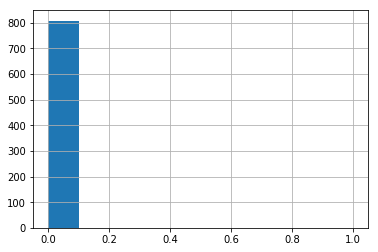

In [35]:
#sales_estimation_binning.iloc[sales_estimation_binning.index.values in [ 7643,  5147]]
#year_of_first_purchase
#sales_estimation_binning.loc[cust_no_per_decile[0], :]['Monitor'].hist(label='Computer', color='g')
#bars=('Roll 1','Roll 2','Roll 3','Roll 4','Roll 5')
#plt.bar(sales_estimation_binning.loc[cust_no_per_decile[0], :]['Monitor'], color='g')
#sales_estimation_binning.loc[cust_no_per_decile[0], :]['Computer'].hist(label='Computer')
sales_estimation_binning.loc[cust_no_per_decile[0], :]['Standard Chair'].hist(label='Standard Chair')
#sales_estimation_binning.index(7643)
# cust_no_per_decile[0]
#sales_estimation_binning.index.values
'''
Number of Prior Year Transactions    0.212137
year_of_first_purchase    0.130842
Language    0.133918
Monitor    0.286288
Office Supplies    0.083007
'''

In [36]:
sales_estimation_binning['year_of_first_purchase_REAL']=sales_estimation_binning['year_of_first_purchase']
sales_estimation_binning['Historical Sales Volume_REAL']=sales_estimation_binning['Historical Sales Volume']

In [37]:
sales_estimation_binning.head()

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies,year_of_first_purchase_REAL,Historical Sales Volume_REAL
index_val,,,,,,,,,,,,,,,,,,
13869,79.694881,0.423061,6,-41.786236,650311.200000,17.0,1995,1,1,1,500.0,0.0,0,0,0,1,1995,650311.200000
2381,1316.798076,0.833333,9,188.762981,470800.000000,14.0,1981,1,1,3,8.0,1.0,0,0,0,0,1981,470800.000000
11621,79.694881,0.474187,6,-41.319308,208866.666667,10.0,1994,1,1,3,300.0,0.0,0,0,0,1,1994,208866.666667
10758,79.694881,0.135634,4,-44.411271,673733.790476,20.0,2003,4,0,4,8.0,0.0,0,0,0,1,2003,673733.790476
6243,238.503471,0.950905,9,-3.742881,55050.000000,15.0,1978,4,1,1,3.0,0.0,0,0,0,1,1978,55050.000000


In [38]:
sales_estimation_binning['year_of_first_purchase'], bins_years = \
pd.qcut(sales_estimation_binning['year_of_first_purchase'], q=no_bins, retbins=True, duplicates="drop", labels=False)
        
sales_estimation_binning['Historical Sales Volume'], bins_hist = \
pd.qcut(sales_estimation_binning['Historical Sales Volume'], q=no_bins, retbins=True, duplicates="drop", labels=False)

In [39]:
sales_estimation_binning['prob_bin'], bins_prob = \
pd.cut(sales_estimation_binning['prob'], no_bins, retbins=True, duplicates="drop", labels=False)

In [40]:
bins_prob

array([-0.001,  0.1  ,  0.2  ,  0.3  ,  0.4  ,  0.5  ,  0.6  ,  0.7  ,
        0.8  ,  0.9  ,  1.   ])

In [41]:
#sales_estimation_binning['prob_bin'].value_counts()
sales_estimation_binning[sales_estimation_binning['profit']==9]['prob_bin'].value_counts()

9    247
8    194
7    117
6     68
5     47
4     45
3     38
2     32
1     20
Name: prob_bin, dtype: int64

In [42]:
sales_estimation_binning['year_of_first_purchase_bin_cut'], bins_years2 = \
pd.cut(sales_estimation_binning['year_of_first_purchase_REAL'], no_bins, retbins=True, duplicates="drop", labels=False)

In [43]:
print(bins_years2)

[1925.908 1935.2   1944.4   1953.6   1962.8   1972.    1981.2   1990.4
 1999.6   2008.8   2018.   ]


In [44]:
print(bins_years)
print(bins_hist)

[1926. 1979. 1985. 1989. 1991. 1993. 1995. 1997. 1999. 2009. 2018.]
[3.09843333e+03 8.96760000e+04 1.56443429e+05 2.26085520e+05
 3.05193720e+05 4.00912512e+05 5.21097600e+05 6.78805920e+05
 9.26219600e+05 1.46075930e+06 3.44121258e+07]


In [57]:
sales_estimation_binning.to_csv("sales_estimation_binning_v9_half_test.csv", encoding='utf-8')
#sales_estimation_binning.head()

In [46]:
#sales_estimation_binning.loc[cust_no_per_decile[0], :].head()
corr=sales_estimation_binning[sales_estimation_binning['profit']==0].corr()
corr

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies,year_of_first_purchase_REAL,Historical Sales Volume_REAL,prob_bin,year_of_first_purchase_bin_cut
sales,1.000000,-0.190908,NaN,0.029793,-0.193252,-0.423111,-0.220409,0.111850,0.040032,-0.022031,-0.143587,0.098174,-0.042135,-0.059624,-0.059624,-0.534324,-0.221734,-0.117904,-0.102619,-0.190583
prob,-0.190908,1.000000,NaN,-0.930575,0.127076,0.288380,-0.025486,0.018891,-0.109795,-0.022917,0.046605,-0.081197,0.390033,0.551931,0.551931,0.043642,-0.071960,0.260714,0.977686,-0.075947
profit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
profit_actual,0.029793,-0.930575,NaN,1.000000,-0.083605,-0.106450,0.008339,0.006100,0.124563,-0.005654,-0.069201,-0.012099,-0.388710,-0.550059,-0.550059,0.189840,0.056653,-0.297183,-0.973281,0.057419
Historical Sales Volume,-0.193252,0.127076,NaN,-0.083605,1.000000,0.429440,0.169780,-0.079869,-0.039020,-0.075653,0.334601,-0.089124,0.043412,0.061431,0.061431,0.114598,0.155778,0.534895,0.105729,0.143039
Number of Prior Year Transactions,-0.423111,0.288380,NaN,-0.106450,0.429440,1.000000,-0.084131,0.013254,-0.040479,0.008850,0.244203,-0.205388,0.006964,-0.006494,-0.006494,0.675110,-0.095225,0.257269,0.175804,-0.107002
year_of_first_purchase,-0.220409,-0.025486,NaN,0.008339,0.169780,-0.084131,1.000000,-0.461226,-0.046935,0.053369,0.020581,0.076571,0.073037,0.092149,0.092149,-0.147616,0.938118,0.123794,-0.011238,0.850549
quarter_of_purchase,0.111850,0.018891,NaN,0.006100,-0.079869,0.013254,-0.461226,1.000000,0.001479,-0.053177,-0.108156,-0.067526,-0.045657,-0.021447,-0.021447,0.050503,-0.370187,-0.060760,0.008617,-0.275201
repurchase_method,0.040032,-0.109795,NaN,0.124563,-0.039020,-0.040479,-0.046935,0.001479,1.000000,-0.068919,0.001955,-0.052351,0.016784,0.023751,0.023751,0.123975,-0.062791,-0.163974,-0.108471,-0.071388
Last Transaction Channel,-0.022031,-0.022917,NaN,-0.005654,-0.075653,0.008850,0.053369,-0.053177,-0.068919,1.000000,-0.096694,0.059093,0.013884,-0.006669,-0.006669,0.026195,0.066817,-0.044451,-0.008555,0.042449


In [47]:
#df['Campaign Period Sales'].plot(kind=''
import seaborn as sns
plt.figure(figsize=(18,6))
#sns.countplot(sales_estimation_binning.loc[cust_no_per_decile[0], :]['Number of Prior Year Transactions'])
#bars=('Roll 1','Roll 2','Roll 3','Roll 4','Roll 5')
#plt.bar(sales_estimation_binning.loc[cust_no_per_decile[0], :]['Monitor'], color='g')


#sns.barplot(x="p1_country", y='liked', hue='same_country', data=data, ci=None);

#sns.barplot(y="profit", x="Computer", hue="Monitor", data=sales_estimation_binning.loc[cust_no_per_decile[0], :], ci=None);

#sns.countplot(data=sales_estimation_binning.loc[cust_no_per_decile[0], :], x='Historical Sales Volume')
#sns.distplot(df['Historical Sales Volume'])

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

[1926. 1979. 1985. 1989. 1991. 1993. 1995. 1997. 1999. 2009. 2018.]


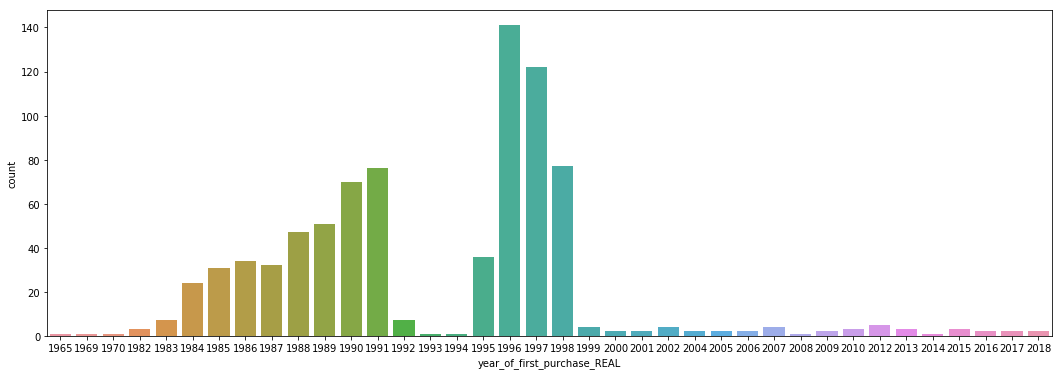

In [48]:
plt.figure(figsize=(18,6))
print(bins_years)
sns.countplot(data=sales_estimation_binning.loc[cust_no_per_decile[0], :], x='year_of_first_purchase_REAL')
# year_of_first_purchase

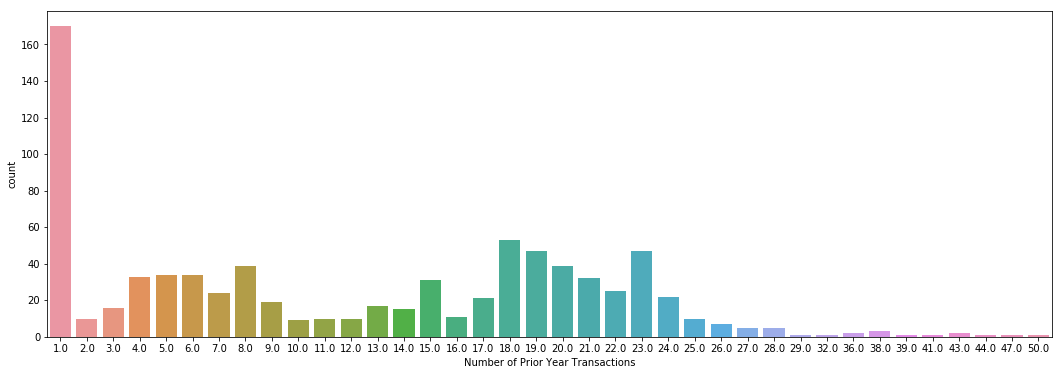

In [49]:
plt.figure(figsize=(18,6))
sns.countplot(data=sales_estimation_binning.loc[cust_no_per_decile[0], :], x='Number of Prior Year Transactions')

In [50]:
sales_estimation_binning.loc[cust_no_per_decile[0], :]['Number of Prior Year Transactions']==18

#np.where(sales_estimation_binning.loc[cust_no_per_decile[0], :]['Number of Prior Year Transactions']==18)

#xx=sales_estimation_binning.loc[cust_no_per_decile[0], :]['Number of Prior Year Transactions']==18
xx=sales_estimation_binning.loc[cust_no_per_decile[0], :]
#xx.index
#xx.index

yy=xx[xx['Number of Prior Year Transactions']==18]
yy.head()

#cust_no_per_decile[xx.index]

#sales_estimation_binning[sales_estimation_binning.loc[cust_no_per_decile[0], :]['Number of Prior Year Transactions']==18].index()

,sales,prob,profit,profit_actual,Historical Sales Volume,Number of Prior Year Transactions,year_of_first_purchase,quarter_of_purchase,repurchase_method,Last Transaction Channel,num_employee_converted,Do Not Direct Mail Solicit,Standard Chair,Monitor,Computer,Office Supplies,year_of_first_purchase_REAL,Historical Sales Volume_REAL,prob_bin,year_of_first_purchase_bin_cut
index_val,,,,,,,,,,,,,,,,,,,,
8101,79.694881,0.001991,0,-45.631816,2,18.0,6,2,0,2,30.0,1.0,0,0,0,1,1996,195661.44,0,7
8711,79.694881,0.024433,0,-45.426853,8,18.0,6,1,1,3,30.0,0.0,0,0,0,1,1997,970224.00,0,7
6576,79.694881,0.006925,0,-45.586754,9,18.0,6,1,1,1,300.0,0.0,0,0,0,1,1997,1527721.20,0,7
1095,79.694881,0.016218,0,-45.501883,4,18.0,6,1,1,1,3.0,0.0,0,0,0,1,1997,305442.72,0,7
5748,79.694881,0.015630,0,-45.507256,6,18.0,3,4,1,4,3.0,0.0,0,0,0,1,1990,566649.60,0,6


In [61]:
df.loc[[8101]]

,Customer Number,Campaign Period Sales,Historical Sales Volume,Date of First Purchase,Number of Prior Year Transactions,Do Not Direct Mail Solicit,Do Not Email,Do Not Telemarket,Repurchase Method,Last Transaction Channel,Desk,Executive Chair,Standard Chair,Monitor,Printer,Computer,Insurance,Toner,Office Supplies,Number of Employees,Language
8101,18089646.0,0.0,195661.44,1996-05-01,18.0,1.0,0.0,0.0,AUTO RENEW,AUTO RENEW,N,N,N,N,N,N,N,N,Y,11-50,English


In [58]:
data =[]
for i in range(10):
    decile_no = 10 - i
    # number of customers
    customer_count = sales_estimation_binning[sales_estimation_binning['profit'] == i]['profit_actual'].count()
    # Actual Profitability Per Customer
    profit_mean = sales_estimation_binning[sales_estimation_binning['profit'] == i]['profit_actual'].mean()
    # total profit
    profit_sum = sales_estimation_binning[sales_estimation_binning['profit'] == i]['profit_actual'].sum()
    data += [[decile_no, customer_count, round(profit_mean, 2), round(profit_sum, 2)]]
    
columns = ['Decile', 'Number of Customers', 'Actual Profitability Per Customer', 'Total Profit']

gains_chart = pd.DataFrame(data, columns=columns)

gains_chart.sort_values(by=['Decile']).to_csv("gains_chart_v9.csv", encoding='utf-8')


In [52]:
gains_chart.sort_values(by=['Decile'])

,Decile,Number of Customers,Actual Profitability Per Customer,Total Profit
9,1,808,159.58,128943.74
8,2,808,-17.42,-14078.78
7,3,808,-39.43,-31858.86
6,4,808,-42.67,-34478.06
5,5,808,-43.81,-35394.98
4,6,808,-44.37,-35852.74
3,7,808,-44.77,-36170.44
2,8,808,-45.10,-36438.58
1,9,808,-45.31,-36610.02
0,10,809,-45.58,-36875.47


In [64]:
for col in ['Standard Chair', 'Monitor', 'Computer', 'Office Supplies',\
            'repurchase_method', 'Do Not Direct Mail Solicit']:
    print('for_column_{}={}'.format(col, sales_estimation_binning[sales_estimation_binning['profit']
                                                             == 9][col].value_counts()[1]))
        #print('{}={}'.format(col, sales_estimation_binning[col].value_counts()[1]))

#, 'num_employee_converted'
    
#sales_estimation_binning[sales_estimation_binning['profit'] == 9].value_counts()

for_column_Standard Chair=84
for_column_Monitor=117
for_column_Computer=92
for_column_Office Supplies=343
for_column_repurchase_method=547
for_column_Do Not Direct Mail Solicit=126


In [ ]:
sales_estimation_binning.loc[[14302], :]

In [ ]:
xx=df.loc[cust_no_per_decile[9], :]
xx['Language'].value_counts()
#xx.info()